In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 16'

Choose the source and the  run_dir on the basis of the number of k-points and shift

In [3]:
source = 'nscf/bnds_40-kpoints_8.save'
#source = 'nscf/bnds_40-kpoints_8-shift_1.save'
#source = 'nscf/bnds_40-kpoints_10-shift_1.save'
#source = 'nscf/bnds_40-kpoints_100-sampling_random.save'

#run_dir = 'rt_k8_width40'
#run_dir = 'rt_k8_shift'
#run_dir = 'rt_k10_shift'
#run_dir = 'rt_k100_random'
run_dir = 'rt_k8_width100'
#run_dir = 'rt_k8_width200'

## Construction of the FixSymm folder

The first step of this procedure is represented by the construction of the Yambo base folder with the SAVE directory. 

We use the tools of Dataset to build the SAVE folder and choose various folder as source path.

In [4]:
y_save = D.Dataset(label='y_save',run_dir=run_dir,pre_processing='yambo')

In [5]:
y_save.pre_processing_function(source_dir=source)

Create folder rt_k8_width100
execute :  cd nscf/bnds_40-kpoints_8.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_8.save/SAVE rt_k8_width100
execute :  cd rt_k8_width100;OMP_NUM_THREADS=1 yambo


In [6]:
ypp_input = I.YppIn('ypp -y',folder=y_save.run_dir)

input = ypp_input.getInput()
input['Efield1'] = [1.0,0.0,0.0]
input['Efield2'] = [0.0,1.0,0.0]
print(input)
ypp_input.write(y_save.run_dir+'/ypp.in')

execute :  cd rt_k8_width100; ypp -y -F ypp.in
fixsyms
Btheta = 0.000000e+00 deg
Bpsi = 0.000000e+00 deg
% Efield2
 0.0 | 1.0 | 0.0 |   
%
% Efield1
 1.0 | 0.0 | 0.0 |   
%
BField = 0.000000e+00 T

execute :  cd rt_k8_width100; ypp -y -F ypp.in


Build the FixSymm folder and run yambo_rt (without argument) to build the r_setup

In [7]:
string = 'cd %s; ypp -F ypp.in'%y_save.run_dir
print(string)
os.system(string)

cd rt_k8_width100; ypp -F ypp.in


0

In [8]:
fixSymmPath = y_save.run_dir+'/FixSymm'
string = 'cd %s; yambo_rt'%fixSymmPath
print(string)
os.system(string)

cd rt_k8_width100/FixSymm; yambo_rt


0

## Real Time Analysis

Define the code that will run yambo_rt and the dataset for the rt computations. Note that no pre_processing is nedded for this dataset since the FixSymm folder that contains the rt SAVE is already built.

We have performed some tests to set the parameters of the run, in particular : 

* the damping is needed, without damping the the dN does not follows the shape of the fluence of the field but show a gaussian like behavior.

* A convergence test has been performed on the number of RTBands, the actual choice is [5,10], we have checked that increasing this interval produces only a small change in the dN at the end of the NETime

In [9]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',suffix='carriers',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt
Suffix for post_processing :  carriers


In [10]:
run_dir = os.path.join(run_dir,'FixSymm')
print(run_dir)

rt_k8_width100/FixSymm


In [11]:
yambo_rt = D.Dataset(label='yambo_rt',run_dir=run_dir)

We add various runs to the dataset. First of all we define the basic elements of the input file

In [12]:
#rt_input = I.YamboIn('yambo_rt -q p -v ip -V qp',folder=yambo_rt.run_dir) #old yambo
rt_input = I.YamboIn('yambo_rt -n p -v ip -V qp',folder=yambo_rt.run_dir)

time_step = 10 #as
field_int = 1000.0 #kWLm2
field_width = 100 #40 #fs
sim_time = 6*field_width
rt_bands = [5,10]

rt_parameters = {
     'Field1_Int'   : [field_int,'kWLm2'],
     'Field1_Width' : [field_width,'fs'],
     'Field1_kind'  : 'QSSIN',
     'RTstep'       : [time_step,'as'],
     'NETime'       : [sim_time,'fs'],
     'RTBands'      : rt_bands,
     'IOtime'       : [[1.0,5.0,1.0],'fs'], # Carriers - GF - output
     'GfnQP_Wv'     : [0.05,0.00,0.00],     # Constant damping valence
     'GfnQP_Wc'     : [0.05,0.00,0.00],     # Constant damping conduction
     'GfnQP_E'      : [1.00, 1.00, 1.00],   # Scissor
     'RT_CPU'       : "%s.1.1.1"%mpi_run[-1]
}

for k,v in rt_parameters.items():
    rt_input[k] = v

In [13]:
# circular polarization spanning a given frequencies range
freq_range = [1.15,1.25,1.35,1.45,1.55,1.65,1.75,1.85]
for f in freq_range:
    pars = { 'Field1_Freq'  : [[f,f],'eV'],
             'Field1_pol'   : 'circular',
             # the two fields reproduce the field used for FixSymm
             'Field1_Dir'   : [1.0,0.0,0.0],
             'Field1_Dir_circ'   : [0.0,1.0,0.0]
    }
    for k,v in pars.items():
        rt_input[k] = v
    idd = {'pol' : 'circular','freq' : f}
    yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [14]:
# linear polarization with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'linear',
     'Field1_Dir'   : [1.0,0.0,0.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'linear','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [15]:
# circular polarization (reversed) with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'circular',
     'Field1_Dir'   : [0.0,1.0,0.0],
     'Field1_Dir_circ'   : [1.0,0.0,0.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'reversed_circular','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [16]:
# circular polarization (rotated y-> z) with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'circular',
     'Field1_Dir'   : [1.0,0.0,0.0],
     'Field1_Dir_circ'   : [0.0,0.0,1.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'rotated_circular','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [17]:
#print(yambo_rt.runs[2])

In [18]:
yambo_rt.run()

execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt -F freq_1.15-pol_circular.in -J freq_1.15-pol_circular -C freq_1.15-pol_circular
parse file : rt_k8_width100/FixSymm/freq_1.15-pol_circular/o-freq_1.15-pol_circular.carriers
execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt -F freq_1.25-pol_circular.in -J freq_1.25-pol_circular -C freq_1.25-pol_circular
parse file : rt_k8_width100/FixSymm/freq_1.25-pol_circular/o-freq_1.25-pol_circular.carriers
execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt -F freq_1.35-pol_circular.in -J freq_1.35-pol_circular -C freq_1.35-pol_circular
parse file : rt_k8_width100/FixSymm/freq_1.35-pol_circular/o-freq_1.35-pol_circular.carriers
execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt -F freq_1.45-pol_circular.in -J freq_1.45-pol_circular -C freq_1.45-pol_circular
parse file : rt_k8_width100/FixSymm/freq_1.45-pol_circular/o-freq_1.45-pol_circul

In [19]:
yambo_rt.ids

[{'freq': 1.15, 'pol': 'circular'},
 {'freq': 1.25, 'pol': 'circular'},
 {'freq': 1.35, 'pol': 'circular'},
 {'freq': 1.45, 'pol': 'circular'},
 {'freq': 1.55, 'pol': 'circular'},
 {'freq': 1.65, 'pol': 'circular'},
 {'freq': 1.75, 'pol': 'circular'},
 {'freq': 1.85, 'pol': 'circular'},
 {'freq': 1.55, 'pol': 'linear'},
 {'freq': 1.55, 'pol': 'reversed_circular'},
 {'freq': 1.55, 'pol': 'rotated_circular'}]

In [22]:
res = yambo_rt.results[4]

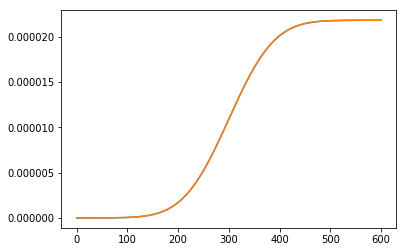

In [23]:
plt.plot(res.time,res.dN_hole)
plt.plot(res.time,res.dN_elec)

We plot the dN_e at the last simulation time in function of the probe frequency

(0, 0.002)

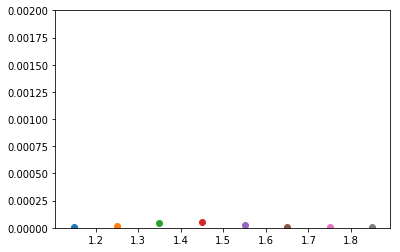

In [24]:
for ind,f in enumerate(freq_range):
    res = yambo_rt.results[ind]
    plt.scatter(f,res.dN_elec[-1])
plt.ylim((0,2e-3))

## ypp post-processing for the rt analysis

Perform the ypp -n o e post-processing using the rt results as input

In [25]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 1',executable='ypp_rt',suffix='YPP-RT_occupations_DATA',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt
Suffix for post_processing :  YPP-RT_occupations_DATA


In [26]:
ypp_noe = D.Dataset(label='ypp_noe',run_dir=run_dir)

In [27]:
ypp_input = I.YppIn('ypp_rt -n o e -V qp',folder=ypp_noe.run_dir)

execute :  cd rt_k8_width100/FixSymm; ypp_rt -n o e -V qp -F ypp.in


In [28]:
input = ypp_input.getInput()
input['QPkrange'][0][3:5] = rt_bands
input['TimeStep'][0] = 100 #20
print(input)

RealTime
RToccupations
TimeStep = 100 fs
% QPkrange
 1 | 512 | 1 | 5 | 10 |   
%
% QPerange
 1 | 512 | 0.0 | -1.000000 |   
%
% TimeRange
 -1.000000 | -1.000000 |  fs 
%



Add the run the dataset. The names of the yambo_rt are given as jobname to the post-processing

In [29]:
for name in yambo_rt.names: 
    idd = 'ypp_'+name
    ypp_noe.append_run(id=idd,input=ypp_input,calculator=code,jobname=name)

In [30]:
ypp_noe.run()

execute :  cd rt_k8_width100/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.15-pol_circular.in
execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.15-pol_circular.in -J freq_1.15-pol_circular -C ypp_freq_1.15-pol_circular
parse file : rt_k8_width100/FixSymm/ypp_freq_1.15-pol_circular/o-freq_1.15-pol_circular.YPP-RT_occupations_DATA
execute :  cd rt_k8_width100/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.25-pol_circular.in
execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.25-pol_circular.in -J freq_1.25-pol_circular -C ypp_freq_1.25-pol_circular
parse file : rt_k8_width100/FixSymm/ypp_freq_1.25-pol_circular/o-freq_1.25-pol_circular.YPP-RT_occupations_DATA
execute :  cd rt_k8_width100/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.35-pol_circular.in
execute : cd rt_k8_width100/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.35-pol_circular.in -J freq_1.35-pol_circular -C ypp_freq_1.35-pol_circular
parse fi

In [31]:
ypp_noe.ids

['ypp_freq_1.15-pol_circular',
 'ypp_freq_1.25-pol_circular',
 'ypp_freq_1.35-pol_circular',
 'ypp_freq_1.45-pol_circular',
 'ypp_freq_1.55-pol_circular',
 'ypp_freq_1.65-pol_circular',
 'ypp_freq_1.75-pol_circular',
 'ypp_freq_1.85-pol_circular',
 'ypp_freq_1.55-pol_linear',
 'ypp_freq_1.55-pol_reversed_circular',
 'ypp_freq_1.55-pol_rotated_circular']

Use the output file for showing the neq occupations

In [32]:
res = ypp_noe.results[4].__dict__
res.keys()

dict_keys(['300.000', '0.00000', '200.000', '100.000', '500.000', 'E', '400.000', '600.000'])

In [82]:
last_time = '240.000'

(-0.005, 0.005)

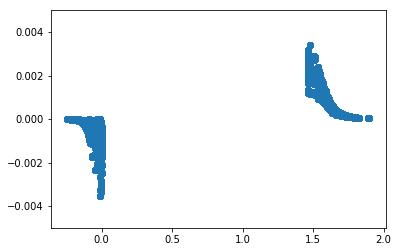

In [86]:
plt.scatter(res['E'],res[last_time])
plt.ylim(-5e-3,5e-3)

We can see, in function of the energy which is the energy gap associated to the maximum
of the promotion of electrons from valence to conduction

In [87]:
for ind,f in enumerate(freq_range):
    res = ypp_noe.results[ind].__dict__
    maxx = max(res[last_time])
    minn = min(res[last_time])
    ind_max = res[last_time].index(maxx)
    ind_min = res[last_time].index(minn)
    deltaEnergy = res['E'][ind_max] - res['E'][ind_min]
    print(f,deltaEnergy)

1.15 1.4626419
1.25 1.4626419
1.35 1.4626419
1.45 1.4626419
1.55 1.4890400000000001
1.65 1.56935
1.75 1.63809
1.85 1.70417


It coincides with the GaAs gap for all the frequencies of the pump. I belive that this pump has a large spread in energy and so all the values of freq_range have a non negligible contribution at the energy gap.

### Analysis of the spin polarization

We analyze the spin polarization for the pump field with circular polarization

In [88]:
# count the total number of carriers with positive energy (the ones that should be detected by the pump)
# for each spin
spin_pol = []
for f in freq_range:
    f_up = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_up_DATA'%(f,f)
    f_dn = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_dn_DATA'%(f,f)
    res_up = C.dict_parser(f_up)
    res_dn = C.dict_parser(f_dn)
    tot_up = 0.
    tot_dn = 0.
    for (E,num) in zip(res_up['E'],res_up[last_time]):
        if E > 0 : tot_up += num
    for (E,num) in zip(res_dn['E'],res_dn[last_time]):
        if E > 0 : tot_dn += num         
    delta = (tot_up-tot_dn)/(tot_up+tot_dn)*100
    spin_pol.append(delta)
print('')
for f,s in zip(freq_range,spin_pol):
    print(f,s)


1.15 0.3876808165337214
1.25 0.4936132910128433
1.35 0.6795825945199986
1.45 0.8205741693174731
1.55 -0.3151174582156793
1.65 -0.3082305616377837
1.75 0.2542238266675687
1.85 0.9026867913070394


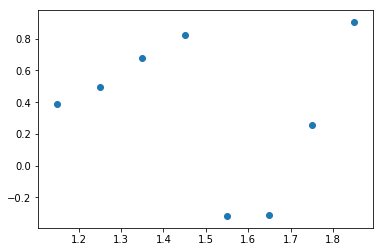

In [92]:
plt.scatter(freq_range,spin_pol)

A different but equivalent way to build the spin polarization...

In [170]:
f_up = 'rt_k100_random/FixSymm/ypp_freq_1.55-pol_circular/o-freq_1.55-pol_circular.YPP-RT_occupations_up_DATA'
f_dn = 'rt_k100_random/FixSymm/ypp_freq_1.55-pol_circular/o-freq_1.55-pol_circular.YPP-RT_occupations_dn_DATA'

In [171]:
data_up = C.dict_parser(f_up)
data_dn = C.dict_parser(f_dn)

In [176]:
f0 = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_up_DATA'%(freq_range[0],freq_range[0])
#print(f0)
data0 = C.dict_parser(f0)
energies = data_up['E']
ind_E0 = 0
for e in energies:
    if e >-0.2 : 
        ind_E0 = energies.index(e)
        break
ind_E0

2448

In [177]:
tot_up = sum(data_up['240.000'][ind_E0:])
tot_dn = sum(data_dn['240.000'][ind_E0:])
delta = (tot_up-tot_dn)/(tot_up+tot_dn)*100
print(delta)

-1334.1866271168628


(-0.005, 0.01)

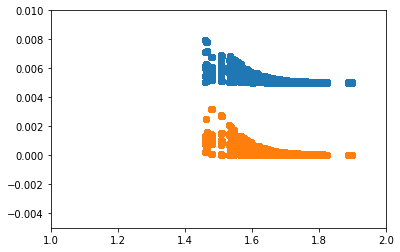

In [188]:
plt.scatter(energies,0.005+np.array(data_up['240.000']))
plt.scatter(energies,data_dn['240.000'])
plt.xlim(1,2)
plt.ylim(-5e-3,1e-2)

0.25590147399999713 0.2578933580000028
0.4097662859999996 0.4138316750000064
0.7737662779999982 0.7843549990000029
1.6878336299999925 1.7157626619999917
2.841999352999996 2.8241443450000103
3.345456123999996 3.3248960600000346
2.9990296520000013 3.0143170120000087
2.139873670999994 2.178858294000004
[0.3876808165337214, 0.4936132910128433, 0.6795825945199986, 0.8205741693174731, -0.3151174582156793, -0.3082305616377837, 0.2542238266675687, 0.9026867913070394]


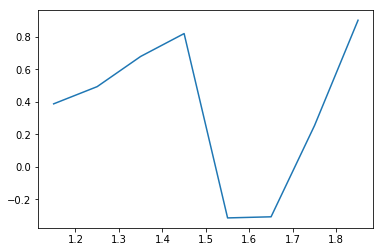

In [133]:
spin_pol = []
for f in freq_range:
    f_up = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_up_DATA'%(f,f)
    f_dn = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_dn_DATA'%(f,f)
    #print(f_up,f_dn)
    res_up = C.dict_parser(f_up)
    res_dn = C.dict_parser(f_dn)
    tot_up = sum(res_up[last_time][ind_E0:])
    tot_dn = sum(res_dn[last_time][ind_E0:])
    print(tot_dn,tot_up)
    delta = (tot_up-tot_dn)/(tot_up+tot_dn)*100
    spin_pol.append(delta)
print(spin_pol)
plt.plot(freq_range,spin_pol)

In [130]:
spin_pol = []
for f in freq_range:
    f_up = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_up_DATA'%(f,f)
    f_dn = run_dir+'/ypp_freq_%s-pol_circular/o-freq_%s-pol_circular.YPP-RT_occupations_dn_DATA'%(f,f)
    res_up = C.dict_parser(f_up)
    res_dn = C.dict_parser(f_dn)
    for ind,E in enumerate(res_up['E']):
        if E > 1:
            E_thresh = ind
            break
    #print(E_thresh)
    tot_up = sum(res_up[last_time][E_thresh:])
    tot_dn = sum(res_dn[last_time][E_thresh:])
    print('%s %.5f %.5f'%(f,tot_up,tot_dn))
    delta = (tot_up-tot_dn)/(tot_up+tot_dn)*100
    spin_pol.append(delta)
print('')
for f,s in zip(freq_range,spin_pol):
    print(f,s)

1.15 0.25789 0.25590
1.25 0.41383 0.40977
1.35 0.78435 0.77377
1.45 1.71576 1.68783
1.55 2.82414 2.84200
1.65 3.32490 3.34546
1.75 3.01432 2.99903
1.85 2.17886 2.13987

1.15 0.3876808165337214
1.25 0.4936132910128433
1.35 0.6795825945199986
1.45 0.8205741693174731
1.55 -0.3151174582156793
1.65 -0.3082305616377837
1.75 0.2542238266675687
1.85 0.9026867913070394


As check we compute the spin polarization also for the linearly polarized pump

In [90]:
f_up = run_dir+'/ypp_freq_1.55-pol_linear/o-freq_1.55-pol_linear.YPP-RT_occupations_up_DATA'
f_dn = run_dir+'/ypp_freq_1.55-pol_linear/o-freq_1.55-pol_linear.YPP-RT_occupations_dn_DATA'
res_up = C.dict_parser(f_up)
res_dn = C.dict_parser(f_dn)
for ind,E in enumerate(res_up['E']):
    if E > 1:
        E_thresh = ind
        break
tot_up = sum(res_up[last_time][E_thresh:])
tot_dn = sum(res_dn[last_time][E_thresh:])
delta = (tot_up-tot_dn)/(tot_up+tot_dn)*100
delta

-1.7650253095615897e-07

And with the circular reversed polarization

In [91]:
f_up = run_dir+'/ypp_freq_1.55-pol_reversed_circular/o-freq_1.55-pol_reversed_circular.YPP-RT_occupations_up_DATA'
f_dn = run_dir+'/ypp_freq_1.55-pol_reversed_circular/o-freq_1.55-pol_reversed_circular.YPP-RT_occupations_dn_DATA'
res_up = C.dict_parser(f_up)
res_dn = C.dict_parser(f_dn)
for ind,E in enumerate(res_up['E']):
    if E > 1:
        E_thresh = ind
        break
tot_up = sum(res_up[last_time][E_thresh:])
tot_dn = sum(res_dn[last_time][E_thresh:])
delta = (tot_up-tot_dn)/(tot_up+tot_dn)*100
delta

0.31508168330530895